In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 손실함수

## (1) 평균 제곱 오차

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

## (2) 교차 엔트로피 오차

In [3]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y + delta))

In [4]:
## 배치용 교차 엔트로피 오차

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

# 2. 최적화

## (1) 수치 미분

In [5]:
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

In [6]:
def function_1(x):
    return 0.01*x**2 + 0.1*x 

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

0.1999999999990898


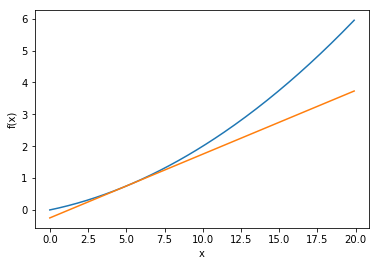

In [7]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

## (2) 기울기

In [8]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

## (3) 경사하강법

In [9]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad # lr : learning rate

    return x, np.array(x_history)

In [10]:
def function_2(x):
    return x[0]**2 + x[1]**2

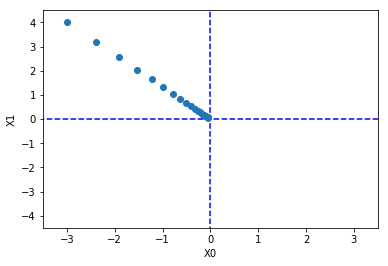

In [11]:
init_x = np.array([-3.0, 4.0])  # 초기값

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

### learning rate의 크기에 따라 얻을 수 있는 결과는 달라진다.

In [12]:
# 너무 큰 경우

init_x = np.array([-3.0, 4.0])  # 초기값
step_num = 100
lr = 10
optimal_x, _ = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)
optimal_x

array([-2.58983747e+13, -1.29524862e+12])

In [13]:
# 너무 작은 경우

init_x = np.array([-3.0, 4.0])  # 초기값
step_num = 100
lr = 1e-10
optimal_x, _ = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)
optimal_x

array([-2.99999994,  3.99999992])

# 3. 학습 알고리즘 구현

## (1) 2층 신경망

In [14]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [15]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads


## (2) 미니배치 구현

In [16]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1
    return T

def get_data():    
    from keras.datasets import mnist
    (x_train, t_train), (x_test, t_test) = mnist.load_data()

    # x flatten

    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2]).astype('float')
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2]).astype('float')

    # x normalize

    x_train /= 255.0
    x_test /= 255.0
    
    t_train = _change_one_hot_label(t_train)        
    t_test = _change_one_hot_label(t_test)
    
    
    return (x_train, t_train), (x_test, t_test)

In [17]:
# mnist 데이터 

(x_train, t_train), (x_test, t_test) = get_data()

/Users/sechang/anaconda/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
%%time
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
#     grad = network.numerical_gradient(x_batch, t_batch) # 원래는 이 방법으로 해야되는데 너무 오래걸린다..
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09751666666666667, 0.0974
train acc, test acc | 0.8020833333333334, 0.8067
train acc, test acc | 0.87645, 0.8799
train acc, test acc | 0.8986333333333333, 0.9023
train acc, test acc | 0.9084166666666667, 0.9108
train acc, test acc | 0.9137833333333333, 0.9166
train acc, test acc | 0.9186166666666666, 0.9206
train acc, test acc | 0.9229, 0.925
train acc, test acc | 0.9263166666666667, 0.928
train acc, test acc | 0.9298, 0.9304
train acc, test acc | 0.9328333333333333, 0.9344
train acc, test acc | 0.9350333333333334, 0.9349
train acc, test acc | 0.9380166666666667, 0.938
train acc, test acc | 0.9410333333333334, 0.9402
train acc, test acc | 0.9424833333333333, 0.9425
train acc, test acc | 0.9447166666666666, 0.9432
train acc, test acc | 0.94625, 0.9439
CPU times: user 50.3 s, sys: 10.1 s, total: 1min
Wall time: 1min 27s


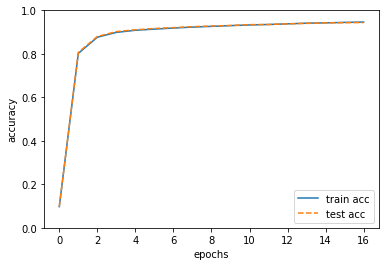

In [19]:
# 정확도 추이

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

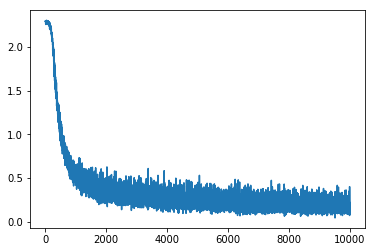

In [20]:
# 손실함수 값 변화 추이

plt.plot(list(range(iters_num)), train_loss_list)